## Bangbang and adaptation

Here, we want to reach a target which is not the target we first see at time $t=0s$. Thus, there is a second target when the first one disappears. Several trajectories are possible.  
A naive approach consists in reaching the first target with a bangbang and then in reaching the second one with another bangbang. But, after many trials, we could predict that the trajectory will be a single bangbang that enables to reach the second target directly.  
So, it will be useful to use a "naivety" parameter that enables to show different shapes of trajectory.  

We assume:  
$\newcommand{\intervalle}[2]{\left[#1\mathclose{}\mathpunct{};#2\right]}
\newcommand{\intervallefo}[2]{\left[#1\mathclose{}\mathpunct{};#2\right[}
\newcommand{\intervalleof}[2]{\left]#1\mathclose{}\mathpunct{};#2\right]}
\newcommand{\intervalleoo}[2]{\left]#1\mathclose{}\mathpunct{};#2\right[}$  
$$
u(t) = \mathbb 1_{\intervalle{0}{\rho\cdot T_1}} \cdot U_1 - \mathbb 1_{\intervalleof{\rho\cdot T_1}{T_1}} \cdot U_1 + \mathbb 1_{\intervalle{T_1}{r\cdot T_2}} \cdot U_2 - \mathbb 1_{\intervalleof{r\cdot T_2}{T_2}} \cdot U_2 + \mathbb 1_{\intervalleoo{T_2}{+\infty}} \cdot U_\infty
$$

We will solve the following differential equation, which represents a linear model of the eye, on the previous intervals:  
  
$$
\dfrac{d\dot{x}(t)}{dt} = -\frac{1}{\tau}\cdot\dot{x}(t)+u(t)
$$


In [735]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as alea
%matplotlib inline
from decimal import Decimal
import time
import pandas as pd

In [694]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('e', {
    help : 'merge cell below',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.merge_cell_below();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [738]:
debut = time.time()
record = pd.DataFrame()
nt = 10
dt = 0.00001
tf = 0.1

Xsave = np.zeros((nt, int(tf/dt)+1))
Vsave = np.zeros((nt, int(tf/dt)+1))
Usave = np.zeros((nt, int(tf/dt)+1))
timeesave = np.zeros((nt, int(tf/dt)+1))
for ii in np.arange(nt):
    tau = 0.013
    x0 = np.zeros(2)
    x1 = 20
    xT2 = 15
    xT1 = (1-ii/(nt-1))*x1+ii/(nt-1)*xT2
    t_Tv1 = 0.02468+0.001739*np.abs(xT1)
    t_T1 =  float(round(Decimal(t_Tv1),3))
    t_Tv2 = 0.02468+0.001739*np.abs(xT1-xT2)
    t_T2 =  float(round(Decimal(t_Tv2),3))
    t_R = 0.1-(t_T1+t_T2)
    T1 = int(t_T1/dt)
    T2 = int(t_T2/dt)
    R = int(t_R/dt)
    timee = np.linspace(0, t_T1+t_T2+t_R, R+T1+T2+1)
    timee_ms = timee/dt
    k = 0.0001

    def fact(n): 
        """The factorial function
        Returns n!, that is n x (n-1) x (n-2) x ... x 1
        Recursive implementation
        """
        if n == 0:
            return 1
        else:
            return(n*fact(n-1))


    # definition of A and B
    A = np.zeros((2,2))
    B = np.zeros(2)
    for i in np.arange(2):
        for j in np.arange(i,2):
            A[i,j] = dt**(j-i)/fact(j-i)
    A[1, 1] = 1-dt/tau
    B[1] = dt

    def power(A, n): 
        """
        renvoie A puissance n où A est une matrice carrée

        """
        if n == 0:
            return(np.eye(int(np.sqrt(np.size(A)))))
        elif n == 1:
            return A
        else:
            if n % 2 == 0:
                A_half = power(A, n//2)
                return(A_half.dot(A_half))
            else:
                A_half = power(A, (n-1)//2)
                return(A.dot(A_half.dot(A_half)))

    def A_pow(A):
        A_pow_array = np.zeros((T1+T2+R+1,2,2))

        for i in np.arange(T1+T2+R+1):
            A_pow_array[i] = power(A,i)
        return A_pow_array

    A_pow_array = A_pow(A)

    def pow_fast(n):
        return A_pow_array[n]

    ci0_array = np.zeros(T1+T2+R+1)

    for i in np.arange(T1+T2+R+1):
        ci0_array[i] = (pow_fast(i).dot(B))[0]

    ci1_array = np.zeros(T1+T2+R+1)

    for i in np.arange(T1+T2+R+1):
        ci1_array[i] = (pow_fast(i).dot(B))[1]

    #ci2_array = np.zeros(T+R+1)

    #for i in np.arange(T+R+1):
    #    ci2_array[i] = (pow_fast(i).dot(B))[2]

    #ci3_array = np.zeros(T+R+1)

    #for i in np.arange(T+R+1):
    #    ci3_array[i] = (pow_fast(i).dot(B))[3]

    ci = np.array([ci0_array, ci1_array])

    def expectation(u, t):
        """Computation of the expectation of the state vector at timee t, given u
        """
        if t == 0:
            return x0
        else:
            return pow_fast(t).dot(x0)+(ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

    def variance(u, t):
        """Computation of the variance of the state vector at timee t, given u
        """
        return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

    n = 500 # number of rho's values

    rho = np.linspace(0.5,0.999,n) # rho's tested values

    U1moins = xT1/tau/t_T1*(1-np.exp(-rho*t_T1/tau))/(1-(1-rho)*np.exp(-rho*t_T1/tau)-rho*np.exp((1-rho)*t_T1/tau))
    U1plus = U1moins*(1-np.exp((1-rho)*t_T1/tau))/(1-np.exp(-rho*t_T1/tau))

    r = np.linspace(0.5,0.999,n) # rho's tested values

    U2moins = (xT2-xT1)/tau/t_T2*(1-np.exp(-r*t_T2/tau))/(1-(1-r)*np.exp(-r*t_T2/tau)-r*np.exp((1-r)*t_T2/tau))
    U2plus = U2moins*(1-np.exp((1-r)*t_T2/tau))/(1-np.exp(-r*t_T2/tau))

    u1 = np.zeros((n-5, T1+T2+R+1))

    for i in np.arange(n-5):
        rhoT = int(np.round(T1*rho[i]))
        u1[i,:] = np.concatenate((U1plus[i]*np.ones(rhoT), U1moins[i]*np.ones(T1-rhoT), np.zeros(R+T2+1)))

    u2 = np.zeros((n-5, T2+R+1))

    for i in np.arange(n-5):
        rT = int(np.round(T2*r[i]))
        u2[i,:] = np.concatenate((U2plus[i]*np.ones(rT), U2moins[i]*np.ones(T2-rT), np.zeros(R+1)))

    variancev1 = np.zeros((n-5, T1+T2+R+1))

    for i in np.arange(n-5):
        for j in np.arange(T1+T2+R+1):
            variancev1[i,j] = variance(u1[i,:], j)

    variancev2 = np.zeros((n-5, T2+R+1))

    for i in np.arange(n-5):
        for j in np.arange(T2+R+1):
            variancev2[i,j] = variance(u2[i,:], j)

    somme = np.zeros(n-5)
    for i in np.arange(n-5):
        for j in T1+np.arange(T2+R+1):
            somme[i] += variancev1[i,j]

    somme2 = np.zeros(n-5)
    for i in np.arange(n-5):
        for j in T2+np.arange(R+1):
            somme2[i] += variancev2[i,j]

    ind_best = np.argmin(somme)
    rho = rho[ind_best]

    ind_best2 = np.argmin(somme2)
    r = r[ind_best2]

    rhoT = int(np.round(T1*rho))
    U1moins = xT1/tau/t_T1*(1-np.exp(-rho*t_T1/tau))/(1-(1-rho)*np.exp(-rho*t_T1/tau)-rho*np.exp((1-rho)*t_T1/tau))
    U1plus = U1moins*(1-np.exp((1-rho)*t_T1/tau))/(1-np.exp(-rho*t_T1/tau))

    rT = int(np.round(T2*r))
    U2moins = (xT2-xT1)/tau/t_T2*(1-np.exp(-r*t_T2/tau))/(1-(1-r)*np.exp(-r*t_T2/tau)-r*np.exp((1-r)*t_T2/tau))
    U2plus = U2moins*(1-np.exp((1-r)*t_T2/tau))/(1-np.exp(-r*t_T2/tau))

    pos1 = np.concatenate((tau*U1plus*(timee[0:rhoT]-tau*(1-np.exp(-timee[0:rhoT]/tau))),xT1-tau*U1moins*(t_T1-timee[rhoT:T1]+tau*(1-np.exp((t_T1-timee[rhoT:T1])/tau)))))

    pos2 = np.concatenate((xT1+tau*U2plus*(timee[T1:(T1+rT)]-t_T1-tau*(1-np.exp((t_T1-timee[T1:(T1+rT)])/tau))),xT2-tau*U2moins*(t_T1+t_T2-timee[(T1+rT):(T1+T2)]+tau*(1-np.exp((t_T1+t_T2-timee[(T1+rT):(T1+T2)])/tau)))))

    vel1 = np.concatenate((tau*U1plus*(1-np.exp(-timee[0:rhoT]/tau)),tau*U1moins*(1-np.exp((t_T1-timee[rhoT:T1])/tau))))

    vel2 = np.concatenate((tau*U2plus*(1-np.exp((t_T1-timee[T1:(T1+rT)])/tau)),tau*U2moins*(1-np.exp((t_T1+t_T2-timee[(T1+rT):(T1+T2)])/tau))))

    Uinf = np.zeros(R+1)
    velinf = np.zeros(R+1)
    posinf = xT2*np.ones(R+1)

    U = np.concatenate((U1plus*np.ones(rhoT),U1moins*np.ones(T1-rhoT),U2plus*np.ones(rT),U2moins*np.ones(T2-rT),np.zeros(R+1)))
    V = np.concatenate((vel1,vel2,velinf))
    X = np.concatenate((pos1,pos2,posinf))

    record_one = pd.DataFrame([{'signal':U,
                                'position':X,
                                'velocity':V,
                                'time':timee_ms}],
                                index=[ii])
    record = pd.concat([record, record_one])

fin = time.time()


In [740]:
(fin-debut)/60

35.28108215729396

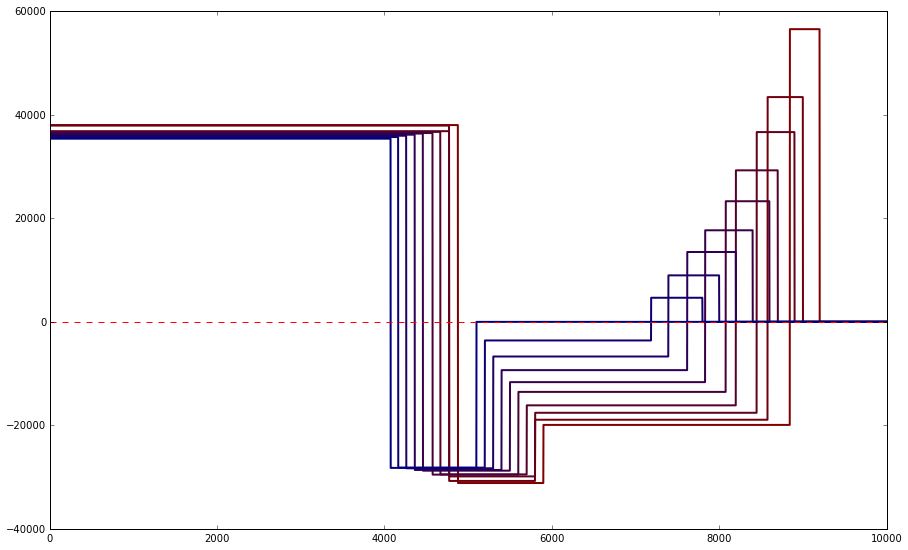

In [741]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for ii in np.arange(nt):
    ax.plot(record.time[ii], record.signal[ii], lw=2, color=(0.5*(1-ii/(nt-1)),0,0.5*ii/(nt-1)))

ax.plot([0,(t_T1+t_T2+t_R)/dt],[0,0],'r--')

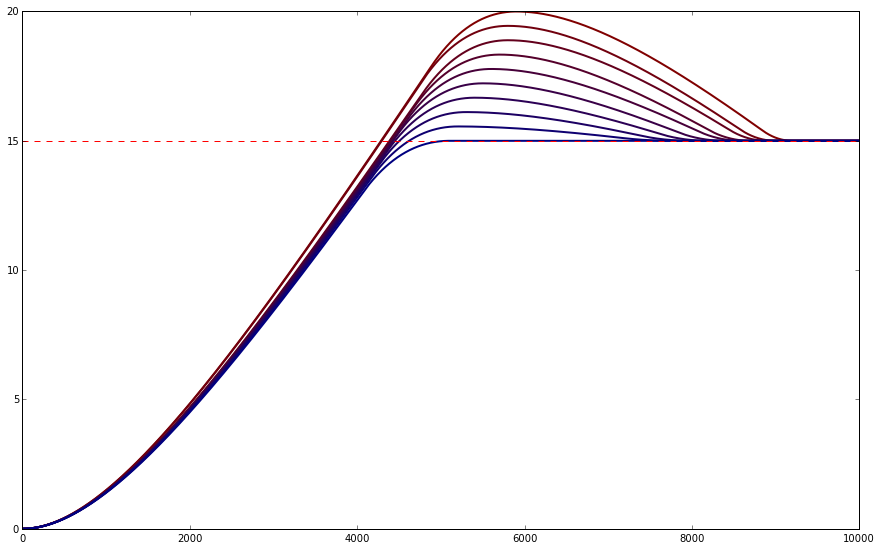

In [742]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for ii in np.arange(nt):
    ax.plot(record.time[ii], record.position[ii], lw=2, color=(0.5*(1-ii/(nt-1)),0,0.5*ii/(nt-1)))
#ax.plot(timeesave[8], Xsave[8], lw=2)

ax.plot([0,(t_T1+t_T2+t_R)/dt],[xT2,xT2],'r--')

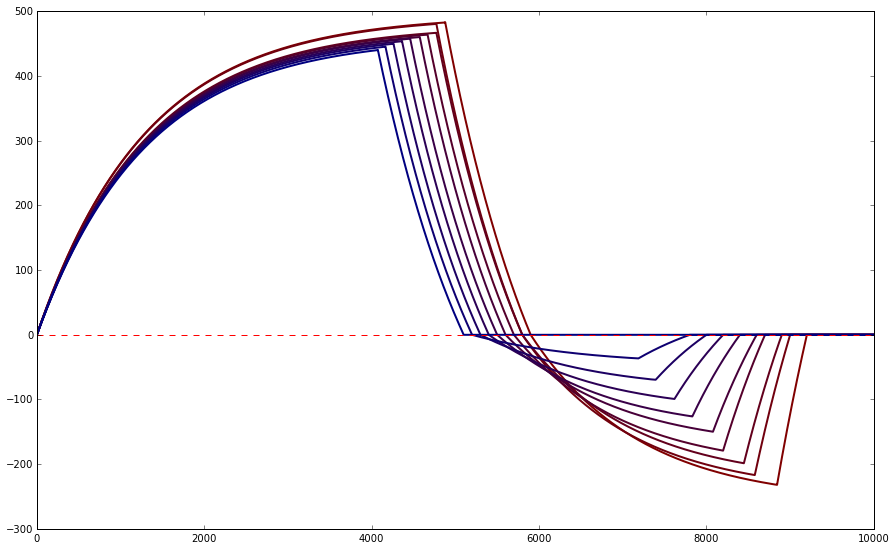

In [743]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
for ii in np.arange(nt):
    ax.plot(record.time[ii], record.velocity[ii], lw=2, color=(0.5*(1-ii/(nt-1)),0,0.5*ii/(nt-1)))

ax.plot([0,(t_T1+t_T2+t_R)/dt],[0,0],'r--')